total_data_7727이 이미 abnormal인 애들만 모아둔게 맞음. itemid 개수 == 4068

total_data에 적혀있는 마지막 날짜는 d-1임. (d-day 아님.)
<br>
x, y: 환자 id 별로 sorting 된 data
<br>
x: 환자 별 sorting

# library

In [1]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# df_all

In [3]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('./dsml_data/x_(7727,10,4068).npy')
y = np.load('./dsml_data/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from tensorflow.keras.models import load_model
lstm2 = load_model('./dsml_data/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

## ReLU에는 inverse 해서 학습해서 구한 diff
## Sign에는 모두 1로 바꿔서 학습해서 구한 diff

In [4]:
# 3)
# FEATURES
a = pd.read_csv('./dsml_data/total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 


preds2_mean_lst = []
results = []
preds = lstm2.predict(X_test)
preds_mean = np.mean(preds)

# COMPUTE BASELINE
from tensorflow.keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()
baseline_bce = bce(y_test, preds).numpy()
results.append({'feature':'BASELINE','baseline_bce':baseline_bce}) 

for k in tqdm(range(len(features))):

    # REVERSE ALL FEATURE K
    save_col = X_test[:,:,k].copy()
    X_test[:,:,k] = 1
#     X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
#     X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
#     X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])

    # COMPUTE BCE WITH FEATURE K REVERSED, preds2_mean_list
    preds2 = lstm2.predict(X_test)
#     preds2_mean = np.mean(preds2)
    preds2_mean_lst.append(np.mean(preds2))
    
    loss_bce = bce(y_test, preds2).numpy()
    results.append({'feature':features[k],'bce':loss_bce})
    X_test[:,:,k] = save_col

100%|██████████| 4068/4068 [33:47<00:00,  2.01it/s]


# data processing

In [ ]:
df1 = pd.DataFrame(results)

preds2_mean_lst.insert(0, np.NaN)
preds2_mean_lst

preds_mean_lst = []
for i in range(len(df1)):
    if i == 0:
        preds_mean_lst.append(preds_mean)
    else:
        preds_mean_lst.append(np.nan)

len(preds_mean_lst)
preds_mean_lst


df1['preds_mean'] = preds_mean_lst
df1['preds2_mean'] = preds2_mean_lst

######################################################################
df_all_best = df1.copy()

base_value = df1.iloc[0,1]
df_all_best['baseline_bce'] = base_value
df_all_best
df_all_best['diff'] = df_all_best['bce']-df_all_best['baseline_bce']

base_preds = df1.iloc[0,3]
df_all_best['preds_mean'] = base_preds
df_all_best['diff_preds'] = df_all_best['preds2_mean'] - df_all_best['preds_mean']
df_all_best

df_all_best = df_all_best.drop(index=[0])
df_all_best = df_all_best.sort_values(by=['diff', 'diff_preds'])

#######################################################################

diffdf = df_all_best[['feature','diff']]
diffdf = diffdf.sort_values(by='diff')

diffpreds_df = df_all_best[['feature','diff_preds']]
diffpreds_df = diffpreds_df.sort_values(by='diff_preds')


# df_all_best.to_csv('df_all_best_for_meth1.csv',index = False)
# diffdf.to_csv('df_all_diff_for_meth1.csv',index = False)
# diffpreds_df.to_csv('df_all_preds_for_meth1.csv',index = False)

# ❗❗❗❗❗lib실행 후 여기부터!!!! data_load

In [4]:
all_best = pd.read_csv('./dsml_data/df_all_best_for_meth1.csv')
all_diff = pd.read_csv('./dsml_data/df_all_diff_for_meth1.csv')
all_preds = pd.read_csv('./dsml_data/df_all_preds_for_meth1.csv')
all_best_for_ReLU = pd.read_csv('./dsml_data/df_all_best.csv')

# ReLU

In [5]:
for i,j in enumerate(all_best_for_ReLU['diff']):
    if j <= 0:
        all_best_for_ReLU['diff'][i] = 0
all_best_for_ReLU

<ipython-input-5-86b9ebd9b2c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_best_for_ReLU['diff'][i] = 0


,feature,baseline_bce,bce,diff
0,51006,1.014362,1.001220,0.000000
1,63323026201,1.014362,1.006389,0.000000
2,51277,1.014362,1.006995,0.000000
3,0,1.014362,1.009931,0.000000
4,55390000401,1.014362,1.010688,0.000000
...,...,...,...,...
4063,10019055302,1.014362,1.041859,0.027498
4064,54817525,1.014362,1.043492,0.029130
4065,67434504,1.014362,1.046829,0.032467
4066,74606211,1.014362,1.051030,0.036668


# Sign

In [6]:
for i,j in enumerate(all_best['diff_preds']):
    if j>0:
        all_best['diff_preds'][i] = 1
#     elif j==0:
#         all_best['diff_preds'][i] = 0
    elif j<0:
        all_best['diff_preds'][i] = -1

<ipython-input-6-6c161a626d96>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_best['diff_preds'][i] = -1
<ipython-input-6-6c161a626d96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_best['diff_preds'][i] = 1


# Method1
```
Method1 = all_best_for_ReLU['diff'] * all_best['diff_preds']

Method1 순서대로(내림차순) sorting
```

In [7]:
ReLU_sort = all_best_for_ReLU.sort_values('feature').reset_index(drop = True)
# ReLU_sort['diff']
Sign_sort = all_best.sort_values('feature').reset_index(drop = True)
# Sign_sort['diff_preds']

Method1 = ReLU_sort.copy()
Method1.drop(['baseline_bce', 'bce'], axis = 1, inplace = True)

Method1['diff_preds'] = Sign_sort['diff_preds']

Method1['Method1'] = ReLU_sort['diff'] * Sign_sort['diff_preds']
Method1 = Method1.sort_values('Method1', ascending = False)

In [8]:
# Method1.to_csv('Method1.csv', index = False)

# Graph
```
1. data (x_(7727,10,4068).npy, y_(7727,1))를 가져와서 사망, 생존자를 나눠. (.isin도 있음.)
2. feature importance 상위 10개 가져와.

```

In [9]:
x = np.load('./dsml_data/x_(7727,10,4068).npy') # x에 있는 정보: item에 대한 반응
y = np.load('./dsml_data/y_(7727,1).npy') # y에 있는 정보: 생존 사망 결과 ==> admission에 있음.

In [10]:
# 사망자 idx
dead_idx = np.where(y==1)
dead_idx

# 생존자 idx
surv_idx = np.where(y!=1)
surv_idx

(array([   0,    1,    2, ..., 7721, 7724, 7725], dtype=int64),)

(array([   3,   16,   18, ..., 7722, 7723, 7726], dtype=int64),)

In [11]:
surv_idx[0] # 0번째를 뽑아줘야 for문에 하나씩 들어가더라.

array([   3,   16,   18, ..., 7722, 7723, 7726], dtype=int64)

In [12]:
# 사망자 list
dead_lst = []
for idx in dead_idx[0]:
    dead_lst.append(x[idx])

# dead_lst


# 생존자 list
surv_lst = []
for idx in surv_idx[0]:
    surv_lst.append(x[idx])

# surv_lst

In [13]:
dead = np.array(dead_lst)
surv = np.array(surv_lst)
# dead
# surv

In [14]:
len(dead)
len(surv)

len(dead) + len(surv) == 7727


4718

3009

True

In [66]:
surv_idx #같음. 확인

(array([   3,   16,   18, ..., 7722, 7723, 7726], dtype=int64),)

In [73]:
# tuple로 묶인 ndarray를 list로 바꾸는 다양한 방법들
# list(list(surv_idx)[0])
# list((surv_idx)[0])

In [61]:
pd.options.display.min_rows = 10

In [75]:
# x_surv =
# '4차원은 잘못된 거임.'
# x[surv_idx, :, :]
# 
'3차원으로 나와야함.'
x[surv_idx[0], :, :]

'3차원으로 나와야함.'

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [99]:
x_surv = x[surv_idx[0], :, :]

In [108]:
# item 별, day 별, 모든 환자 합
# item은 순서대로 x에 들어있음.

# total_data
# total_data['ITEMID']
# total_data['ITEMID'].sort_values() # 이 순서대로 x에 들어있음.
total_data.sort_values('SUBJECT_ID')['ITEMID'].unique() # 이렇게는 안들어가 있는건 맞지...? 그 때 total_data 만든 코드에서 dic을 생각해보면 sorting 했었음.

# total_data.sort_values('SUBJECT_ID')

total_data['ITEMID'].sort_values().unique()
item_list = total_data['ITEMID'].sort_values().unique()

array([      50882,           0,    74302401, ..., 52544007730,
       51079086920, 54738091301], dtype=int64)

array([          0,       50803,       50804, ..., 87701071218,
       87701083336, 87701089415], dtype=int64)

In [109]:
lab_top

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

In [111]:
lab_top_idx = []
for i in lab_top:
    a = list(item_list).index(i)
    lab_top_idx.append(a)

lab_top_idx


[119, 157, 26, 8, 139, 52, 276, 61, 20, 55]

In [113]:
# 생존자 3009명의 D-10 ~ D-1 feature 별 abnormal sum
result1 = []
for i in lab_top_idx: # item 별
    for j in range(10): # day 별
        result1.append(x_surv[:,j,i].sum()) # item 별, day 별, 모든 환자 합.

# x의 idx: [환자, d-day, item]

In [123]:
result1 = np.array(result1) # 1차원
result1 = result1.reshape(10,-1) # 2차원
df_lab_top_res = pd.DataFrame(result1) # df로 변환
df_lab_top_res.columns = [f'D-{i}' for i in range(10,0,-1)] # colnames d-10 ~ d-1 지정
df_lab_top_res.index = lab_top # 인덱스를 itemid로 지정

In [124]:
# 비율을 볼 거니까 생존자 수x_surv.shape[0] == 3009로 나눔.
for i in lab_top:
    df_lab_top_res.loc[f'{i}_생존 비율'] = df_lab_top_res.loc[i]/x_surv.shape[0]

In [115]:
# lab_top
# x_surv.shape

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

(3009, 10, 4068)

In [125]:
df_lab_top_res

,D-10,D-9,D-8,D-7,D-6,D-5,D-4,D-3,D-2,D-1
51003,96.000000,124.000000,147.000000,148.000000,160.000000,156.000000,153.000000,126.000000,98.000000,55.000000
51148,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50868,72.000000,84.000000,73.000000,97.000000,114.000000,108.000000,112.000000,74.000000,86.000000,69.000000
50813,97.000000,108.000000,111.000000,130.000000,110.000000,127.000000,136.000000,77.000000,55.000000,22.000000
51120,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,2.000000,1.000000
50908,21.000000,19.000000,20.000000,18.000000,23.000000,22.000000,16.000000,15.000000,8.000000,2.000000
51482,37.000000,49.000000,51.000000,50.000000,59.000000,50.000000,52.000000,47.000000,22.000000,18.000000
50917,7.000000,6.000000,14.000000,10.000000,15.000000,10.000000,10.000000,9.000000,6.000000,5.000000
50862,202.000000,198.000000,254.000000,239.000000,259.000000,252.000000,272.000000,228.000000,208.000000,161.000000
50911,47.000000,49.000000,66.000000,69.000000,59.000000,55.000000,45.000000,36.000000,24.000000,6.000000


In [132]:
# 사망자 4718명의 D-10 ~ D-1 feature 별 abnormal sum
x_dead = x[dead_idx[0], :, :]

result2 = []
for i in lab_top_idx:
    for j in range(10):
        result2.append(x_dead[:,j,i].sum()) # item 별, day 별 합

result2 = np.array(result2) # 1차원
result2 = result2.reshape(10,-1) # 2차원
df_lab_top_res2 = pd.DataFrame(result2)
df_lab_top_res2.columns = [f'D-{i}' for i in range(10, 0, -1)]
df_lab_top_res2.index = lab_top


for i in lab_top:
    df_lab_top_res2.loc[f'{i}_사망 비율'] = df_lab_top_res2.loc[i]/x_dead.shape[0]

In [133]:
# 사망한 4718명에 대한 비율 추이 그래프 그리기
df_lab_top_res_trans = df_lab_top_res.transpose()
df_lab_top_res2_trans = df_lab_top_res2.transpose()

In [134]:
df_lab_top_res_trans
df_lab_top_res2_trans

,51003,51148,50868,50813,51120,50908,51482,50917,50862,50911,51003_생존 비율,51148_생존 비율,50868_생존 비율,50813_생존 비율,51120_생존 비율,50908_생존 비율,51482_생존 비율,50917_생존 비율,50862_생존 비율,50911_생존 비율
D-10,96.0,2.0,72.0,97.0,1.0,21.0,37.0,7.0,202.0,47.0,0.031904,0.000665,0.023928,0.032237,0.000332,0.006979,0.012296,0.002326,0.067132,0.015620
D-9,124.0,1.0,84.0,108.0,2.0,19.0,49.0,6.0,198.0,49.0,0.041210,0.000332,0.027916,0.035892,0.000665,0.006314,0.016284,0.001994,0.065803,0.016284
D-8,147.0,1.0,73.0,111.0,1.0,20.0,51.0,14.0,254.0,66.0,0.048853,0.000332,0.024261,0.036889,0.000332,0.006647,0.016949,0.004653,0.084413,0.021934
D-7,148.0,0.0,97.0,130.0,0.0,18.0,50.0,10.0,239.0,69.0,0.049186,0.000000,0.032237,0.043204,0.000000,0.005982,0.016617,0.003323,0.079428,0.022931
D-6,160.0,0.0,114.0,110.0,0.0,23.0,59.0,15.0,259.0,59.0,0.053174,0.000000,0.037886,0.036557,0.000000,0.007644,0.019608,0.004985,0.086075,0.019608
D-5,156.0,0.0,108.0,127.0,2.0,22.0,50.0,10.0,252.0,55.0,0.051844,0.000000,0.035892,0.042207,0.000665,0.007311,0.016617,0.003323,0.083749,0.018278
D-4,153.0,0.0,112.0,136.0,0.0,16.0,52.0,10.0,272.0,45.0,0.050847,0.000000,0.037222,0.045198,0.000000,0.005317,0.017281,0.003323,0.090395,0.014955
D-3,126.0,0.0,74.0,77.0,2.0,15.0,47.0,9.0,228.0,36.0,0.041874,0.000000,0.024593,0.025590,0.000665,0.004985,0.015620,0.002991,0.075773,0.011964
D-2,98.0,0.0,86.0,55.0,2.0,8.0,22.0,6.0,208.0,24.0,0.032569,0.000000,0.028581,0.018278,0.000665,0.002659,0.007311,0.001994,0.069126,0.007976
D-1,55.0,1.0,69.0,22.0,1.0,2.0,18.0,5.0,161.0,6.0,0.018278,0.000332,0.022931,0.007311,0.000332,0.000665,0.005982,0.001662,0.053506,0.001994


,51003,51148,50868,50813,51120,50908,51482,50917,50862,50911,51003_사망 비율,51148_사망 비율,50868_사망 비율,50813_사망 비율,51120_사망 비율,50908_사망 비율,51482_사망 비율,50917_사망 비율,50862_사망 비율,50911_사망 비율
D-10,244.0,19.0,207.0,196.0,15.0,31.0,51.0,31.0,403.0,65.0,0.051717,0.004027,0.043875,0.041543,0.003179,0.006571,0.010810,0.006571,0.085418,0.013777
D-9,299.0,18.0,226.0,234.0,10.0,46.0,54.0,27.0,471.0,82.0,0.063374,0.003815,0.047902,0.049597,0.002120,0.009750,0.011446,0.005723,0.099830,0.017380
D-8,332.0,22.0,254.0,271.0,17.0,53.0,76.0,33.0,508.0,100.0,0.070369,0.004663,0.053836,0.057440,0.003603,0.011234,0.016109,0.006994,0.107673,0.021195
D-7,339.0,17.0,281.0,268.0,9.0,46.0,90.0,40.0,531.0,101.0,0.071852,0.003603,0.059559,0.056804,0.001908,0.009750,0.019076,0.008478,0.112548,0.021407
D-6,369.0,19.0,288.0,298.0,16.0,53.0,90.0,31.0,569.0,90.0,0.078211,0.004027,0.061043,0.063162,0.003391,0.011234,0.019076,0.006571,0.120602,0.019076
D-5,384.0,22.0,320.0,322.0,19.0,62.0,90.0,35.0,605.0,108.0,0.081390,0.004663,0.067825,0.068249,0.004027,0.013141,0.019076,0.007418,0.128232,0.022891
D-4,392.0,23.0,331.0,329.0,14.0,59.0,107.0,38.0,601.0,101.0,0.083086,0.004875,0.070157,0.069733,0.002967,0.012505,0.022679,0.008054,0.127384,0.021407
D-3,377.0,17.0,354.0,359.0,8.0,55.0,96.0,48.0,634.0,103.0,0.079907,0.003603,0.075032,0.076092,0.001696,0.011657,0.020348,0.010174,0.134379,0.021831
D-2,340.0,18.0,376.0,404.0,19.0,42.0,88.0,31.0,624.0,94.0,0.072064,0.003815,0.079695,0.085630,0.004027,0.008902,0.018652,0.006571,0.132259,0.019924
D-1,347.0,20.0,473.0,498.0,11.0,62.0,95.0,45.0,546.0,130.0,0.073548,0.004239,0.100254,0.105553,0.002331,0.013141,0.020136,0.009538,0.115727,0.027554


In [137]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['./dsml_data/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

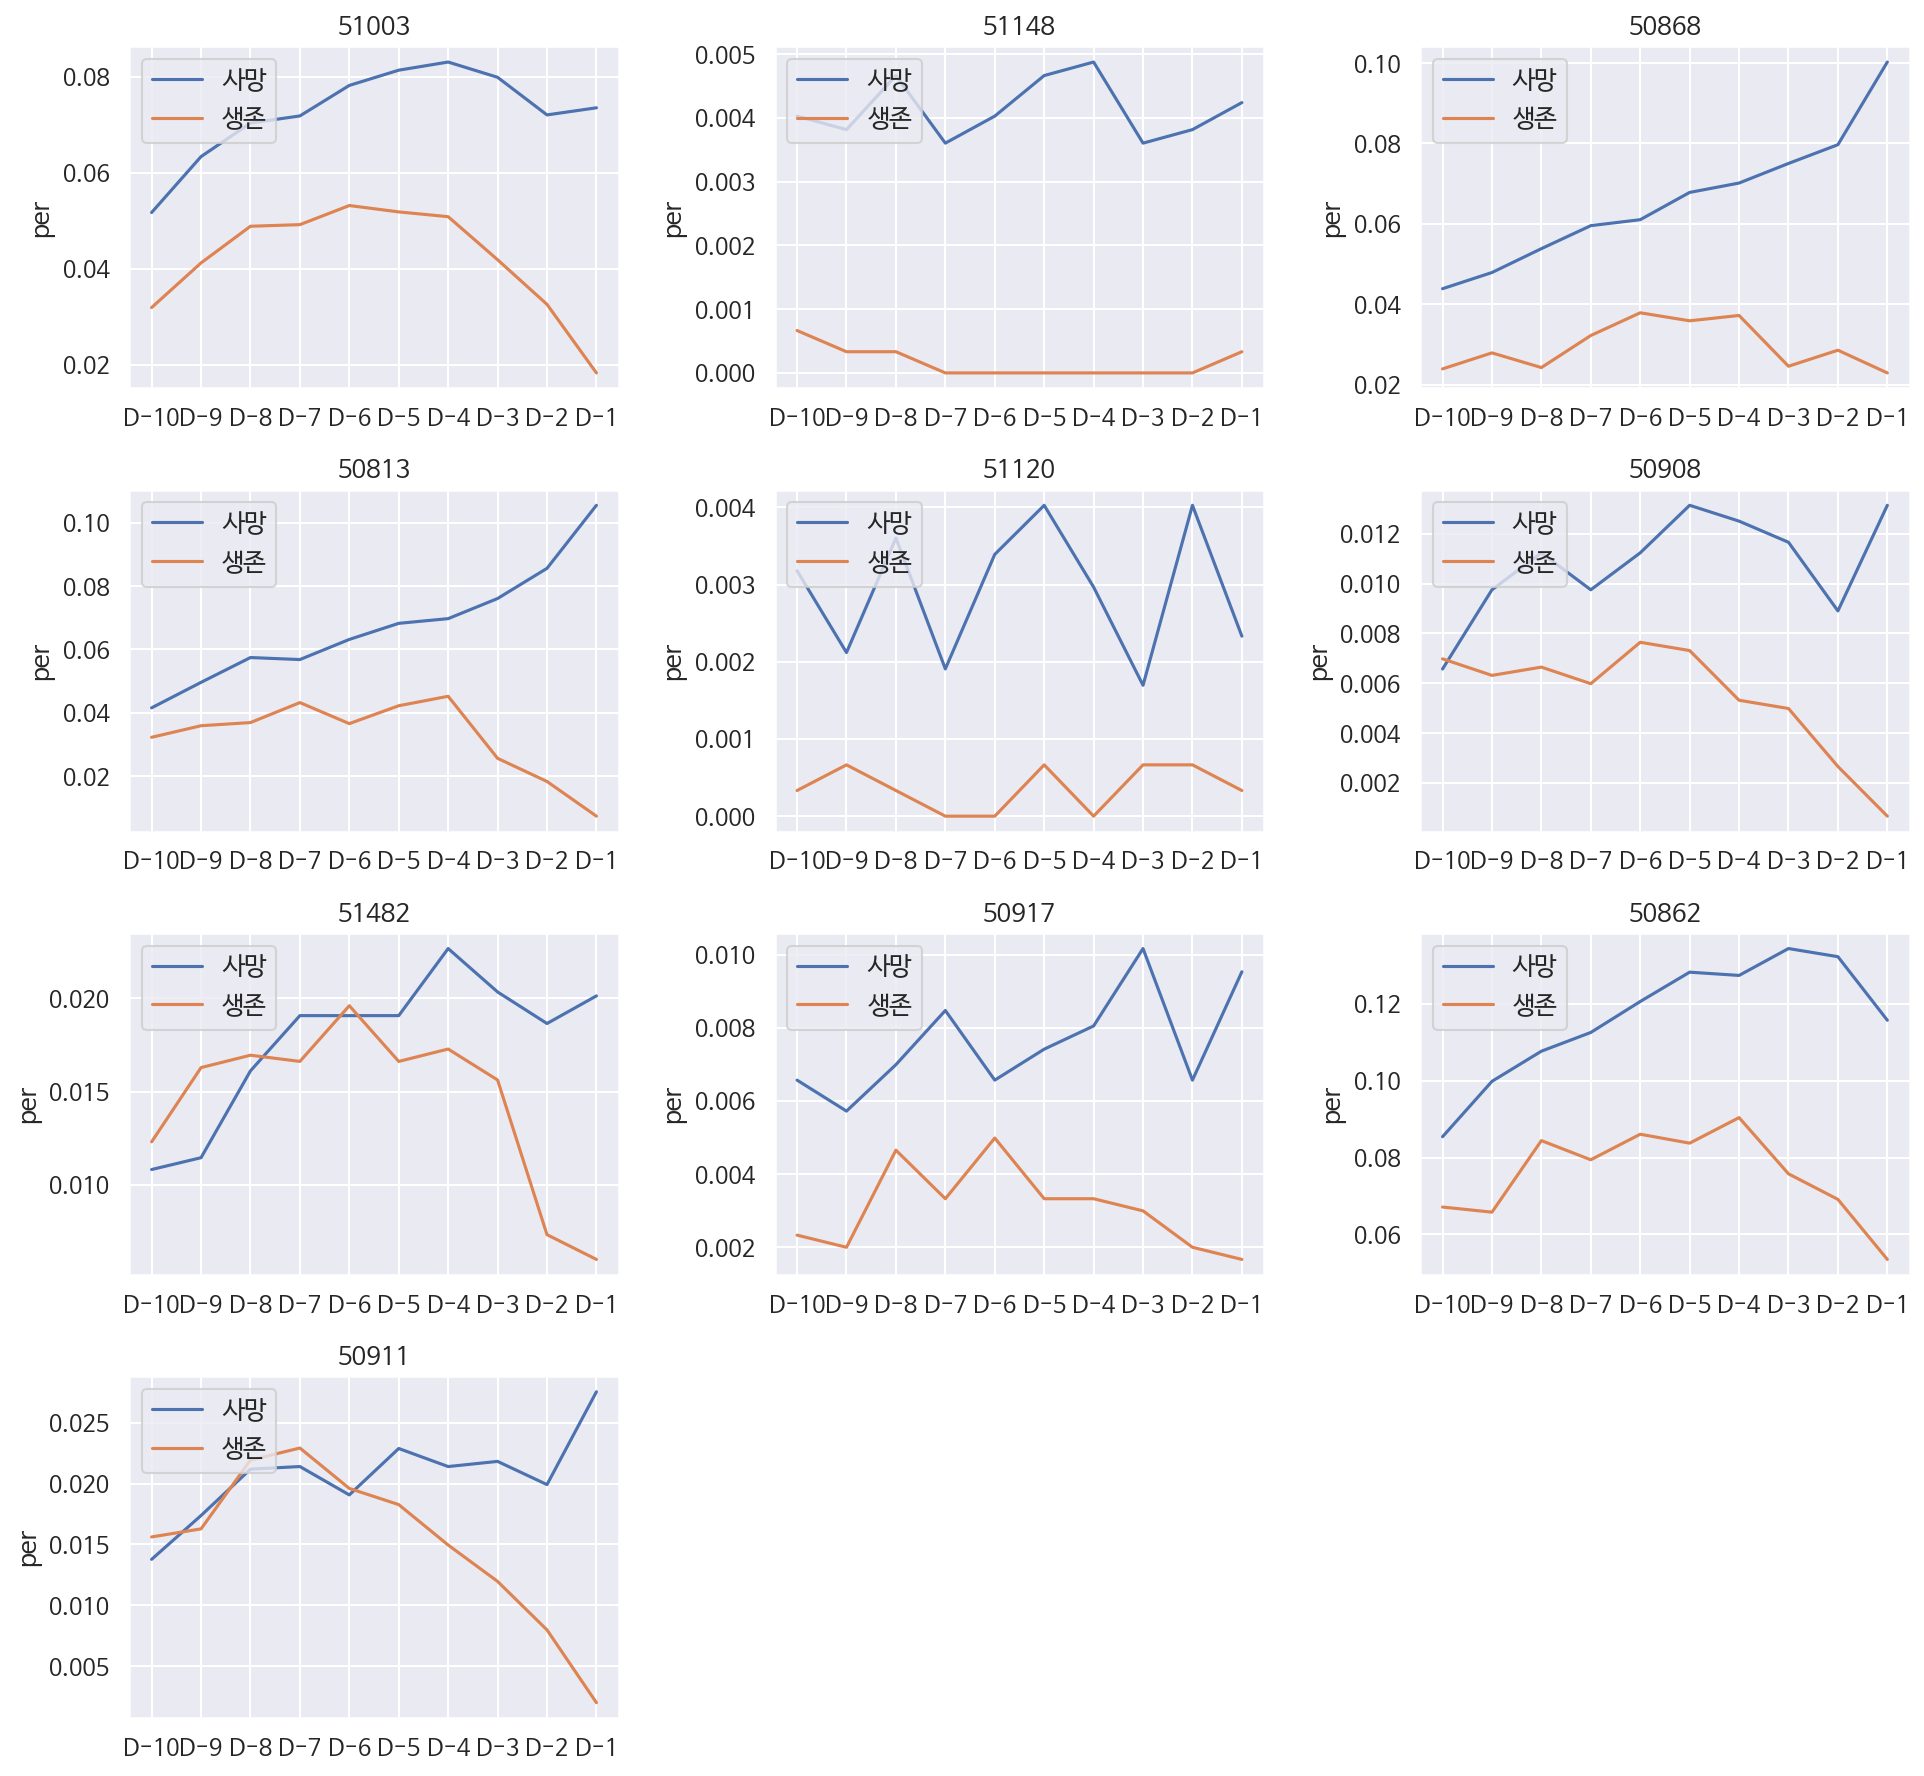

In [139]:
_ = plt.figure(figsize = (13,12), dpi = 150)
for i,f in enumerate(lab_top):
    _ = plt.subplot(4,3,1+i)
    _ = plt.title(f)
    ax = sns.lineplot(data = df_lab_top_res2_trans, x = df_lab_top_res2_trans.index, y = f'{f}_사망 비율')
    ax = sns.lineplot(data = df_lab_top_res_trans, x = df_lab_top_res_trans.index, y = f'{f}_생존 비율')
    _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize = 12)
    _ = ax.set_ylabel('per', fontsize = 12)
plt.tight_layout()

In [ ]:
# 아래 일단 버려봐

# FI는 Method1을 통해 구한 ReLU(diff) * Sign(diff_preds)
```
즉, Method1 df의 Method1열
```

In [16]:
method1 = pd.read_csv('./dsml_data/Method1.csv')
method1

,feature,diff,diff_preds,Method1
0,409606211,0.059180,1.0,0.059180
1,74606211,0.036668,1.0,0.036668
2,67434504,0.032467,1.0,0.032467
3,54817525,0.029130,1.0,0.029130
4,10019055302,0.027498,1.0,0.027498
...,...,...,...,...
4063,51200,0.016966,-1.0,-0.016966
4064,182138167,0.017109,-1.0,-0.017109
4065,50889,0.018246,-1.0,-0.018246
4066,4003822,0.019987,-1.0,-0.019987


In [17]:
feat_lst = method1['feature'].to_list()

In [15]:
# 이렇게 하면 lab은 아예 안나옴. 그래서 lab, pre, pro 별로 top 10 구해야함.
# 그래서 total_data 갖다 쓰는 것.

# feat_top10 = method1['feature'][:10]
# feat_bottom10 = method1['feature'][-10:]

# feat_top10
# feat_bottom10

In [34]:
total_data = pd.read_csv('./dsml_data/total_data_7727.csv') #total_data? total_data_7727?, 7727 써야됨.

total_data

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
0,9,50882,2149-11-09,LAB
1,9,50931,2149-11-09,LAB
2,9,50971,2149-11-09,LAB
3,9,51275,2149-11-09,LAB
4,9,51288,2149-11-09,LAB
...,...,...,...,...
9169850,99985,51288,2181-03-06,LAB
9169851,99985,51279,2182-03-14,LAB
9169852,99985,51006,2182-03-14,LAB
9169853,99985,51221,2182-03-14,LAB


In [35]:
LAB_ITEMID_arr = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()

LAB_feat_top10 = []
LAB_feat_bottom10 = []

for i in feat_lst:
    if i in LAB_ITEMID_arr:
        LAB_feat_top10.append(i)
        if len(LAB_feat_top10) == 10:
            break

len(LAB_feat_top10)


for i in feat_lst[::-1]:
    if i in LAB_ITEMID_arr:
        LAB_feat_bottom10.append(i)
        if len(LAB_feat_bottom10) == 10:
            break

len(LAB_feat_bottom10)

10

10

In [36]:
LAB_feat_top10

# 확인
total_data[total_data['ITEMID'].isin(LAB_feat_top10)]['TYPE'].unique()

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

array(['LAB'], dtype=object)

## top10, bottom10 function

In [37]:
def topbottom(type_in_str):
    ITEMID_arr = total_data[total_data['TYPE'] == type_in_str]['ITEMID'].unique()
    feat_top10 = []
    feat_bottom10 = []

    for i in feat_lst:
        if i in ITEMID_arr:
            feat_top10.append(i)
            if len(feat_top10) == 10:
                break

    for i in feat_lst[::-1]:
        if i in ITEMID_arr:
            feat_bottom10.append(i)
            if len(feat_bottom10) == 10:
                break
    
    return ITEMID_arr, feat_top10, feat_bottom10

In [38]:
_, pre_top, pre_bottom = topbottom('PRE')
_, pro_top, pro_bottom = topbottom('PRO')
_, lab_top, lab_bottom = topbottom('LAB')

# len(pre_top)
# len(pre_bottom)
# len(pro_top)
# len(pro_bottom)
# len(lab_top)
# len(lab_bottom)

In [39]:
total_data[total_data['ITEMID'].isin(pre_bottom)]['TYPE'].unique()
# 근데 이거 유니크는 itemid 서로 안겹치니까 당연히 지들만 나오는건데 왜 확인한거지..? 흠흠...

array(['PRE'], dtype=object)

In [40]:
feat_lst[:10]

[409606211,
 74606211,
 67434504,
 54817525,
 10019055302,
 54858516,
 74706811,
 45006701,
 228125,
 63323016501]

In [41]:
pd.Series(feat_lst[:10]).isin(pro_top)
# .isin(~~)은 series나 df에만 쓰임, list나 ndarray에는 안쓰이므로 pd.Series나 pd.DataFrame를 통해 형변환해서 사용하자.
# .isin(~~)의 괄호 안에는 list, ndarray, Series 들어갈 수 있음.

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8     True
9    False
dtype: bool

## top, bottom check function...
```
제대로 잘 있는지
```

In [42]:
def check_top(top):
    return pd.Series(feat_lst[:204]).isin(top)

def check_bottom(bottom):
    return pd.Series(feat_lst[::-1][:198]).isin(bottom)

In [43]:
check_top(lab_top).sum()
check_top(pre_top).sum()
check_top(pro_top).sum()
check_bottom(lab_bottom).sum()
check_bottom(pre_bottom).sum()
check_bottom(pro_bottom).sum()

10

10

10

10

10

10

In [44]:
lab_top
pre_top
pro_top

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

[409606211,
 74606211,
 67434504,
 54817525,
 10019055302,
 54858516,
 74706811,
 45006701,
 63323016501,
 58177025504]

[228125,
 224270,
 225202,
 228127,
 228128,
 226124,
 225450,
 225794,
 228130,
 225802]

## lab_top 으로 test, 변수설명
```
변수 설명)
feat_lst :  feature list
lab_top : lab에서 FI가 top 10인 Feature들 모아놓은 list
lab_top_df : total_data에서 ITEMID가 lab_top과 같은 애들을 SUBJECT_ID, ITEMID, CHARTTIME, TYPE 열과 함께 볼 수 있도록 모아둔 df
lab_top_times : 환자별 charttime (원래), itemid별 charttime으로 바꿔야하나 생각중.
lab_item : 환자별 & charttime 별 itemid (Multi index임.)

```

In [45]:
lab_top_df = total_data[total_data['ITEMID'].isin(lab_top)]

In [46]:
lab_top_df

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
13,9,50813,2149-11-09,LAB
52,9,50813,2149-11-10,LAB
53,9,50813,2149-11-10,LAB
101,9,50813,2149-11-11,LAB
169,9,50862,2149-11-13,LAB
...,...,...,...,...
9169067,99985,50862,2181-01-29,LAB
9169123,99985,50862,2181-01-30,LAB
9169298,99985,51482,2181-02-02,LAB
9169355,99985,51482,2181-02-03,LAB


In [31]:
len(lab_top_df)
lab_top_df[['SUBJECT_ID','CHARTTIME']]#.unique()

117456

,SUBJECT_ID,CHARTTIME
13,9,2149-11-09
52,9,2149-11-10
53,9,2149-11-10
101,9,2149-11-11
169,9,2149-11-13
...,...,...
9221132,99985,2181-01-29
9221188,99985,2181-01-30
9221363,99985,2181-02-02
9221420,99985,2181-02-03


In [35]:
# lab_top_df.pivot_table # 이거로 multi index 하려 했으나 그냥 df로 하기로함.

In [36]:
# lab_top_df.groupby('SUBJECT_ID')['CHARTTIME']
lab_top_df.groupby('SUBJECT_ID')['CHARTTIME'].unique() #꺅,,, 이게되네..?
lab_top_df.groupby('SUBJECT_ID').count()

SUBJECT_ID
9        [2149-11-09, 2149-11-10, 2149-11-11, 2149-11-1...
21       [2134-09-11, 2134-09-12, 2134-09-13, 2134-09-1...
31                    [2108-08-22, 2108-08-26, 2108-08-29]
36       [2131-05-12, 2131-05-13, 2131-05-16, 2131-05-1...
37       [2183-08-21, 2183-08-22, 2183-08-23, 2183-08-2...
                               ...                        
99863                 [2142-04-13, 2142-04-25, 2142-05-03]
99934                             [2110-02-28, 2110-03-01]
99937                                         [2128-05-11]
99944                                         [2161-02-16]
99985    [2181-01-29, 2181-01-30, 2181-02-02, 2181-02-0...
Name: CHARTTIME, Length: 7314, dtype: object

,ITEMID,CHARTTIME,TYPE
SUBJECT_ID,,,
9,9,9,9
21,41,41,41
31,3,3,3
36,15,15,15
37,8,8,8
...,...,...,...
99863,3,3,3
99934,2,2,2
99937,1,1,1


근데 우리 30일, 20일 그거 안하기로 해서 이거 필요 없잖아..? 또 방향 잃고....

sub = pd.read_csv('/project/guri/data/폐렴환자.csv')
sub

sub['SUBJECT_ID'].nunique() #여기서 외래환자 제거한게 폐렴환자lab이었음.

생각해보면 total_data에 뽑아둔게 이미 abnormal임...
그럼 걍 개수 세면 되는건가..?

In [37]:
lab_top_df.groupby(['ITEMID']).count()

,SUBJECT_ID,CHARTTIME,TYPE
ITEMID,,,
50813,24421,24421,24421
50862,34229,34229,34229
50868,18353,18353,18353
50908,2826,2826,2826
50911,6463,6463,6463
50917,1639,1639,1639
51003,23198,23198,23198
51120,742,742,742
51148,1428,1428,1428


## 버려..? 아니... 환자별로 D-10 ~ D-1로 날짜 처리 해줘야함.

In [77]:
# 함수 만들꺼면 잊지 말고 챙겨야할 cell
# 환자별 charttime.... 근데 우리 필요한건 itemid 별 charttime임... 내가 지금 환자별로 해서 뭐가 안되는 것 같음.
lab_top_times = lab_top_df.groupby(['SUBJECT_ID'])['CHARTTIME'].unique()

In [78]:
lab_top_times

SUBJECT_ID
9        [2149-11-09, 2149-11-10, 2149-11-11, 2149-11-1...
21       [2134-09-11, 2134-09-12, 2134-09-13, 2134-09-1...
31                    [2108-08-22, 2108-08-26, 2108-08-29]
36       [2131-05-12, 2131-05-13, 2131-05-16, 2131-05-1...
37       [2183-08-21, 2183-08-22, 2183-08-23, 2183-08-2...
                               ...                        
99863                 [2142-04-13, 2142-04-25, 2142-05-03]
99934                             [2110-02-28, 2110-03-01]
99937                                         [2128-05-11]
99944                                         [2161-02-16]
99985    [2181-01-29, 2181-01-30, 2181-02-02, 2181-02-0...
Name: CHARTTIME, Length: 7245, dtype: object

In [79]:
# 확인 cell
len(pd.DataFrame(lab_top_times).iloc[0][0])

5

library again for process time

In [80]:
# import datetime as dt
from datetime import datetime, timedelta

In [81]:
# 확인 cell
lab_top_times.index[0]

9

In [82]:
# cnt0 = 0
term = {}
for i,j in enumerate(lab_top_times):
    j = sorted(j)
    days = datetime.strptime(j[-1],'%Y-%m-%d').date() - datetime.strptime(j[0],'%Y-%m-%d').date()
#     days
    if days == timedelta(0):
#         cnt0 += 1
#         if i < 50:
#             j
        term[lab_top_times.index[i]] = {1:j}
#         pass
    else:
        days = int(str(days).split(' ')[0]) #사용자가 이해하기 쉬운형태로 문자열로
#         i,j, days
    #     repr(days) # 객체까지 문자열로
        term[lab_top_times.index[i]] = {days:j}
#     break

# cnt0
len(term) # 아... 0일이 빠진듯... ===> 0일 머무른거 추가해서 다시 했음!!!!!!!!

# cnt0 + len(term) # == 7314여야 함.
# https://wangin9.tistory.com/entry/datetime

7245

In [83]:
term[21]
# term[21].values() # 연속데이터가 아니네..?
val = term[21].values()
list(val)[0]

{148: ['2134-09-11',
  '2134-09-12',
  '2134-09-13',
  '2134-09-14',
  '2134-09-15',
  '2134-09-16',
  '2134-09-18',
  '2134-09-19',
  '2134-09-20',
  '2134-10-01',
  '2135-01-10',
  '2135-01-31',
  '2135-02-01',
  '2135-02-03',
  '2135-02-04',
  '2135-02-06']}

['2134-09-11',
 '2134-09-12',
 '2134-09-13',
 '2134-09-14',
 '2134-09-15',
 '2134-09-16',
 '2134-09-18',
 '2134-09-19',
 '2134-09-20',
 '2134-10-01',
 '2135-01-10',
 '2135-01-31',
 '2135-02-01',
 '2135-02-03',
 '2135-02-04',
 '2135-02-06']

In [84]:
lab_top_df[:10]

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
13,9,50813,2149-11-09,LAB
52,9,50813,2149-11-10,LAB
53,9,50813,2149-11-10,LAB
101,9,50813,2149-11-11,LAB
169,9,50862,2149-11-13,LAB
170,9,50862,2149-11-13,LAB
200,9,50911,2149-11-13,LAB
201,9,50911,2149-11-13,LAB
238,9,50911,2149-11-14,LAB
320,21,50908,2134-09-11,LAB


In [85]:
lab_item = lab_top_df.groupby(['SUBJECT_ID', 'CHARTTIME'])['ITEMID'].unique()

In [86]:
pd.DataFrame(lab_item)

ITEMID
SUBJECT_ID CHARTTIME                 
9          2149-11-09         [50813]
           2149-11-10         [50813]
           2149-11-11         [50813]
           2149-11-13  [50862, 50911]
           2149-11-14         [50911]
...                               ...
99985      2181-01-29  [50813, 50862]
           2181-01-30         [50862]
           2181-02-02         [51482]
           2181-02-03         [51482]
           2181-02-11         [50862]

[65894 rows x 1 columns]

In [87]:
# 확인 cell
lab_top_df['ITEMID'].nunique() #이미 10개인데.... 아니 d-10~ d-1까지만 하면 될 것 같은데...

10

In [88]:
lab_top_times

SUBJECT_ID
9        [2149-11-09, 2149-11-10, 2149-11-11, 2149-11-1...
21       [2134-09-11, 2134-09-12, 2134-09-13, 2134-09-1...
31                    [2108-08-22, 2108-08-26, 2108-08-29]
36       [2131-05-12, 2131-05-13, 2131-05-16, 2131-05-1...
37       [2183-08-21, 2183-08-22, 2183-08-23, 2183-08-2...
                               ...                        
99863                 [2142-04-13, 2142-04-25, 2142-05-03]
99934                             [2110-02-28, 2110-03-01]
99937                                         [2128-05-11]
99944                                         [2161-02-16]
99985    [2181-01-29, 2181-01-30, 2181-02-02, 2181-02-0...
Name: CHARTTIME, Length: 7245, dtype: object

## 다시, 아.... zero array....

### lab_top_times 바뀜...

In [89]:
# lab_top_times = lab_top_df.groupby(['ITEMID'])['CHARTTIME'].unique() #아 내가 이걸 설마 바꿨었구나... 바꿀거면 코드도 바꿨어야지... 당황했잖아...

#### 바로 아래 cell 버려

In [91]:
# 버..려... test cell...
# term = {}
for i,j in enumerate(lab_top_times):
    j = sorted(j)
    j
    dday = datetime.strptime(j[-1],'%Y-%m-%d').date()
#     dday
    
    days = dday - datetime.strptime(j[0],'%Y-%m-%d').date()
    
    d10 = (dday - timedelta(10)).strftime('%Y-%m-%d')
#     d10
    
    if d10 in j:
        'yes'
    else:
        for d in list(range(1,11))[::-1]:
            dday - timedelta(d)
            if (dday - timedelta(d)).strftime('%Y-%m-%d') in j:
                'yes'
            else:
                'no'
#     if days == timedelta(0):
#         pass
# #         term[lab_top_times.index[i]] = {1:j}
# #         lab_top_times.index[i]
#     else:
#         days = int(str(days).split(' ')[0]) #사용자가 이해하기 쉬운형태로 문자열로
#         days
# #         term[lab_top_times.index[i]] = {days:j}
    break

['2149-11-09', '2149-11-10', '2149-11-11', '2149-11-13', '2149-11-14']

datetime.date(2149, 11, 4)

'no'

datetime.date(2149, 11, 5)

'no'

datetime.date(2149, 11, 6)

'no'

datetime.date(2149, 11, 7)

'no'

datetime.date(2149, 11, 8)

'no'

datetime.date(2149, 11, 9)

'yes'

datetime.date(2149, 11, 10)

'yes'

datetime.date(2149, 11, 11)

'yes'

datetime.date(2149, 11, 12)

'no'

datetime.date(2149, 11, 13)

'yes'

## 다시, 아... zero array.... 이어서...

In [92]:
# 일단 환자별로 d-1~d-10 존재하면 해당 날짜 row에 1로 표시.

lab_top_arr = np.zeros((lab_top_df['SUBJECT_ID'].nunique(), 10, 10))

for i,j in enumerate(lab_top_times):
    j = sorted(j)
#     j
    dday = datetime.strptime(j[-1],'%Y-%m-%d').date()
    
    days = dday - datetime.strptime(j[0],'%Y-%m-%d').date()
    
    cnt = 0
    for d in list(range(1,11))[::-1]: #d-10부터 적혀야함. cnt로 해결!
#         dday - timedelta(d)
        if (dday - timedelta(d)).strftime('%Y-%m-%d') in j:
            lab_top_arr[i,cnt] = 1 #환자의 day시점을 1로 채워주기.
            cnt += 1
        else:
            cnt += 1
            pass
#     break
# cnt
# lab_top_arr[0] #0번째 환자 확인
lab_top_arr

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [93]:
lab_item_df = pd.DataFrame(lab_item)#.index()#('CHARTTIME')
lab_item_df.index #아.... .index()는 안되고 .index는 되고..?ㅋ...

MultiIndex([(    9, '2149-11-09'),
            (    9, '2149-11-10'),
            (    9, '2149-11-11'),
            (    9, '2149-11-13'),
            (    9, '2149-11-14'),
            (   21, '2134-09-11'),
            (   21, '2134-09-12'),
            (   21, '2134-09-13'),
            (   21, '2134-09-14'),
            (   21, '2134-09-15'),
            ...
            (99863, '2142-05-03'),
            (99934, '2110-02-28'),
            (99934, '2110-03-01'),
            (99937, '2128-05-11'),
            (99944, '2161-02-16'),
            (99985, '2181-01-29'),
            (99985, '2181-01-30'),
            (99985, '2181-02-02'),
            (99985, '2181-02-03'),
            (99985, '2181-02-11')],
           names=['SUBJECT_ID', 'CHARTTIME'], length=65894)

In [94]:

lab_item_df.iloc[3]
lab_item_df

ITEMID    [50862, 50911]
Name: (9, 2149-11-13), dtype: object

ITEMID
SUBJECT_ID CHARTTIME                 
9          2149-11-09         [50813]
           2149-11-10         [50813]
           2149-11-11         [50813]
           2149-11-13  [50862, 50911]
           2149-11-14         [50911]
...                               ...
99985      2181-01-29  [50813, 50862]
           2181-01-30         [50862]
           2181-02-02         [51482]
           2181-02-03         [51482]
           2181-02-11         [50862]

[65894 rows x 1 columns]

In [95]:
cnt = 0 # 전체 큰 index용...
for i,j in enumerate(lab_top_times):
    cnt_day = 0
    for k in range(len(j)):
        lab_item_df.index[cnt][1]
        lab_item_df.index[cnt]
#         lab_item_df.iloc[cnt].values[0][0] #itemid
        idx = lab_top.index(lab_item_df.iloc[cnt].values[0][0]) #itemid의 lab feat내 FI 순서
        idx
#         lab_top_arr[i][cnt_day][idx]
        cnt += 1
        break
    break
# lab_item_df.index[0][1]
cnt

'2149-11-09'

(9, '2149-11-09')

3

1

## 어렵게 생각하지 말고 다시........

In [96]:
lab_item_df.iloc[0]

ITEMID    [50813]
Name: (9, 2149-11-09), dtype: object

In [97]:
lab_top_times

SUBJECT_ID
9        [2149-11-09, 2149-11-10, 2149-11-11, 2149-11-1...
21       [2134-09-11, 2134-09-12, 2134-09-13, 2134-09-1...
31                    [2108-08-22, 2108-08-26, 2108-08-29]
36       [2131-05-12, 2131-05-13, 2131-05-16, 2131-05-1...
37       [2183-08-21, 2183-08-22, 2183-08-23, 2183-08-2...
                               ...                        
99863                 [2142-04-13, 2142-04-25, 2142-05-03]
99934                             [2110-02-28, 2110-03-01]
99937                                         [2128-05-11]
99944                                         [2161-02-16]
99985    [2181-01-29, 2181-01-30, 2181-02-02, 2181-02-0...
Name: CHARTTIME, Length: 7245, dtype: object

In [98]:
lab_top_arr = np.zeros((lab_top_df['SUBJECT_ID'].nunique(), 10, 10))

for i,j in enumerate(lab_top_times):
    j = sorted(j)
    'j',j
    dday = datetime.strptime(j[-1],'%Y-%m-%d').date()
    
    cnt = 0
    for d in list(range(1,11))[::-1]: #d-10부터 적혀야함. cnt로 해결!
        tt = (dday - timedelta(d)).strftime('%Y-%m-%d')
        if tt in j:
            lab_top_arr[i,cnt] = 1 #환자의 day시점을 1로 채워주기.
####################################################################################################
            lab_item_df.iloc[i].index(tt)
####################################################################################################            
            cnt += 1
        else:
            cnt += 1
            pass
    break
# cnt
lab_top_arr[0] #0번째 환자 확인
# lab_top_arr

('j', ['2149-11-09', '2149-11-10', '2149-11-11', '2149-11-13', '2149-11-14'])

TypeError: 'Index' object is not callable

In [470]:
lab_top_arr[0][0]#[]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [466]:
lab_top # 이건 중요한 순서니까 순서 바뀌면 안됨. 정렬 금지.
# sorted(lab_top)
# np.array(lab_top)[np.where(51148)]
lab_top.index(51003) # 위치 반환

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

0

In [369]:
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### shape = (환자nunique, 10, 10)으로 np.zeros 만들기...
### dday를 기준으로 d-10이 있으면 1로 채우기, 없으면 0 (냅두기)

In [398]:
lab_top_arr = np.zeros((lab_top_df['SUBJECT_ID'].nunique(), 10, 10))

In [399]:
lab_top_arr.shape

(7314, 10, 10)

In [397]:
# # test cell
# lab_top_arr[0]# 맨 앞 환자
# lab_top_arr[0,0] # day 한 줄
# lab_top_arr[0,0] = 1 # day 한 줄 1로 채움.
# lab_top_arr[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [235]:
# test cell
datetime.today().date()-timedelta(1)

datetime.date(2022, 2, 12)

TypeError: unsupported type for timedelta days component: datetime.date

In [142]:
ls

'01-1. EDA 및 환자 추출&Labevents 원본.ipynb'
'01-2. EDA 및 환자 추출 코드 with open으로 다시.ipynb'
'01-3. EDA 및 환자 추출 코드 with open + 함수로 작성 후 정리.ipynb'
'02-2. LSTM,RF Seed Test.ipynb'
'02. 다른 Features 추가, 새로운 DF 생성 (데이터 가공 & 모델링).ipynb'
'02. 다른 Features 추가, 새로운 DF 생성 (데이터 가공 & 모델링) with open으로 가공중,,, 반포기...-Copy1.ipynb'
'02. 다른 Features 추가, 새로운 DF 생성 (데이터 가공 & 모델링) with open으로 가공중,,, 반포기....ipynb'
'03. 최종 LSTM + VotingClassifier guri.ipynb'
'03 시계열, 비시계열 modeling 및 stability 비교 LSH.ipynb'
'03. 기존 VotingClassifier + Feature Selection.ipynb'
'04 Keras Tuner LSH.ipynb'
'05-1. FI guriguri.ipynb'
'05-1. FI guri.ipynb'
'05. LSTM Feature Importance guri.ipynb'
'05 Voting Classifier LSH.ipynb'
'06-1. RESET.ipynb'
'06-2. RESET with open으로 다시.ipynb'
'06. LSTM + Adaboost guri1.ipynb'
'06. LSTM + Adaboost guri2.ipynb'
'11. 3Tables-final 포함.ipynb'
'11. 3Tables-final 포함 with.ipynb'
'12. Multi Output (ft.window)+final.ipynb'
'12. Multi Output (ft.window).ipynb'
'13. Expanded Data (ft. window).ipynb'
'14. 최신 딥러닝 모델 적

In [144]:
pwd

'/project/kelly'

NameError: name 'export' is not defined